# DL Exercise: Working with MRI data

In this exercise we're going to analyse MRI scans of an Achilles tendon. We'll use AlexNet trained to discriminate between healthy and injured tendons, and we'll compare two stages of healing.

In [1]:
# data loading
import os
from glob import glob
import dicom

# input processing
import numpy as np
from scipy import ndimage

# neural networks
import caffe

# visualisation
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sys
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in dicom, np, ndimage, caffe:
    print(mod.__name__, mod.__version__)

python 3.6.4
dicom 0.9.9
numpy 1.14.0
scipy.ndimage 2.0
caffe 1.0.0


# Load the data

The data consist of 4 MRI scans of a patient's leg after Achilles injury - PD and T2\*GREMIN seqences taken in two time points (2016-09-14 and 2017-09-24) after tendon reconstruction.

Slices belonging to a particular scan are stored as [DICOM](https://en.wikipedia.org/wiki/DICOM) files and listed in a `START052699R_<date>_<sequence>_filelist.txt` file:

In [3]:
! head -n 3 START052699R/*/*txt

==> START052699R/20160914/START052699R_20160914_PD_filelist.txt <==
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20160914/DICOM/000/000/087/295/117679/592588/15717287
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20160914/DICOM/000/000/087/295/117679/592588/15717288
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20160914/DICOM/000/000/087/295/117679/592588/15717289

==> START052699R/20160914/START052699R_20160914_T2SGREMIN_filelist.txt <==
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20160914/DICOM/000/000/087/295/117679/592591/15717355
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20160914/DICOM/000/000/087/295/117679/592591/15717377
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20160914/DICOM/000/000/087/295/117679/592591/15717378

==> START052699R/20170924/START052699R_20170924_PD_filelist.txt <==
/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/20170924/DICOM/

In [4]:
inputs_lists = sorted(glob('START052699R/*/*txt'))
inputs_lists

['START052699R/20160914/START052699R_20160914_PD_filelist.txt',
 'START052699R/20160914/START052699R_20160914_T2SGREMIN_filelist.txt',
 'START052699R/20170924/START052699R_20170924_PD_filelist.txt',
 'START052699R/20170924/START052699R_20170924_T2SGREMIN_filelist.txt']

Let's first take a look at a single slice from the first MRI scan (PD sequence taken in 2016) to get an idea how the data look like.

We'll load the data using [pydicom](http://pydicom.readthedocs.io/en/stable/getting_started.html) package, extract some basic information about the scan and visualise the slice.

scan no. 2
voxel size: 3.5 x 0.293 x 0.293


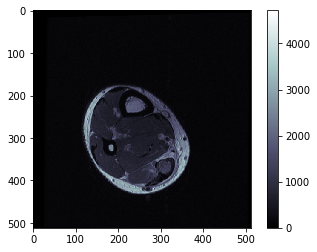

In [5]:
scan = dicom.read_file('START052699R/20160914/DICOM/000/000/087/295/117679/592588/15717287')

# we can use InstanceNumber to sort the slices in a correct order
print(f'scan no. {scan.InstanceNumber}')

# image resolution
pixel_spacing = [float(s) for s in scan.PixelSpacing]
assert len(pixel_spacing) == 2, 'invalid pixel spacing (expected two numbers)'
assert pixel_spacing[0] == pixel_spacing[1], 'pixels aren\'t square'
pixel_spacing = pixel_spacing[0]

# distance between slices in the scan
slice_thickness = float(scan.SliceThickness)

print(f'voxel size: {slice_thickness} x {pixel_spacing} x {pixel_spacing}')

# image itself
image = scan.pixel_array

image_size = image.shape
assert len(image_size) == 2, 'image isn\'t 2D'
assert image_size[0] == image_size[1], 'image isn\'t square'
image_size = image_size[0]

fig, ax = plt.subplots()

img = ax.imshow(image, cmap='bone')
fig.colorbar(img);

---

Now we'll load all 4 scans. They will be stored in a dictionary with (sequence, date) tuples as keys and 3D images as values. We will sort the slices within an image using `InstanceNumber` property to get the correct order (from knee to ankle). We'll also make sure that all slices have the same thickness and pixel size, so they can be processed in the same way.

In [6]:
# my file structure is different than the original one, so I need to modify the paths
original_path = '/workspace0/start/work/czlowiek/achilles/chory/START052699R/MRI/'
my_path = 'START052699R/'

In [7]:
scans = {}

for txt_file in inputs_lists:
    _, date, protocol, _ = os.path.split(txt_file)[1].split('_')
    date = '-'.join((date[:4], date[4:6], date[6:]))

    images = []

    with open(txt_file) as f:
        slices = [dicom.read_file(path.strip().replace(original_path, my_path))
                  for path in f]

    for scan in sorted(slices, key=lambda x: x.InstanceNumber):
        # make sure all slices have the same thickness and pixel size
        if not np.allclose(scan.SliceThickness, slice_thickness):
            print('slice no. {scan.InstanceNumber}, {sequence}, {date} '
                  'has different thickness')
        if not np.allclose([float(p) for p in scan.PixelSpacing], pixel_spacing):
            print('slice no. {scan.InstanceNumber}, {sequence}, {date} '
                  'has different pixel spacing')

        images.append(scan.pixel_array)

    scans[(protocol, date)] = np.array(images)

In [8]:
for (sequence, date), image in scans.items():
    num, x, y = image.shape
    assert (x, y) == (image_size, image_size)
    print(f'{sequence:>10}, {date}, {num} slices')

        PD, 2016-09-14, 25 slices
 T2SGREMIN, 2016-09-14, 40 slices
        PD, 2017-09-24, 25 slices
 T2SGREMIN, 2017-09-24, 40 slices


All images have the same shape and voxel size, but the two sequences differ in length. This is how the whole PD scan looks like, slice by slice:

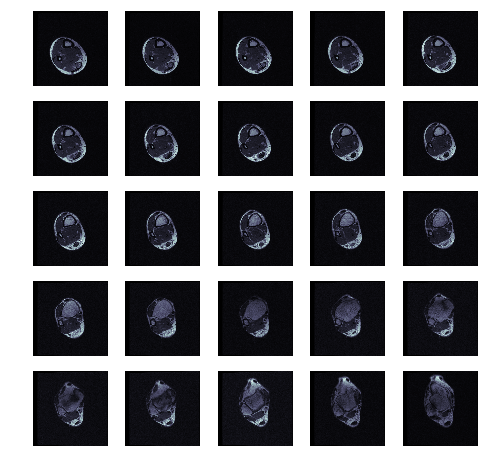

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))

for img, ax in zip(scans[('PD', '2016-09-14')], axs.flatten()):
    ax.imshow(img, cmap='bone')
    ax.set_axis_off()

... and this is T2\*GREMIN sequence from the same time point:

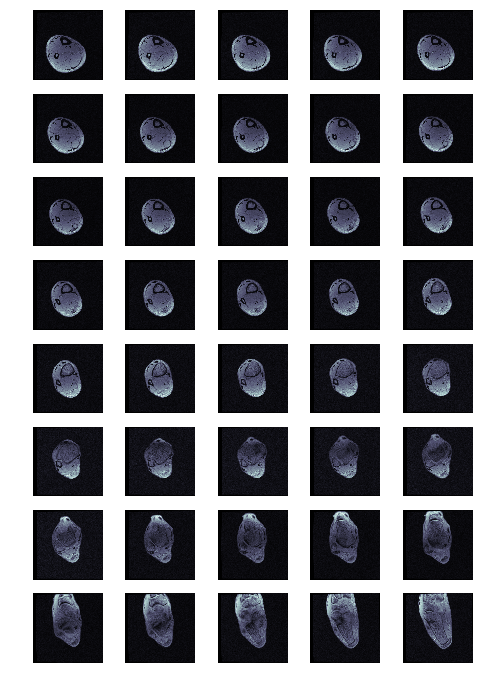

In [10]:
fig, axs = plt.subplots(8, 5, figsize=(8, 12))

for img, ax in zip(scans[('T2SGREMIN', '2016-09-14')], axs.flatten()):
    ax.imshow(img, cmap='bone')
    ax.set_axis_off()

We can also take a look at the sagittal slice:

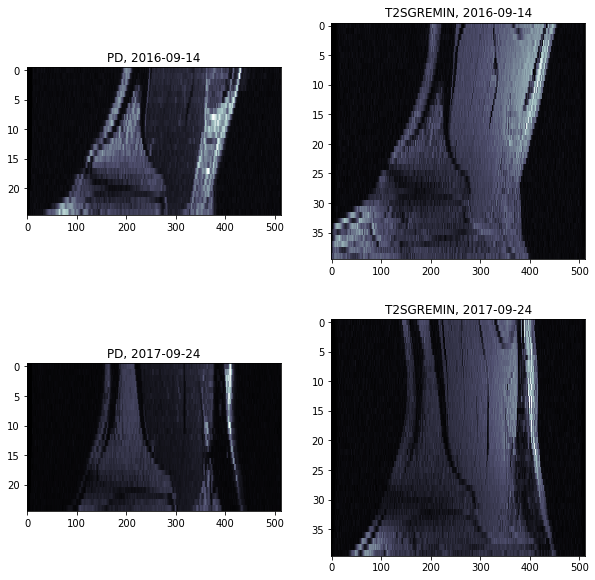

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ((sequence, date), image), ax in zip(scans.items(), axs.flatten()):
    ax.imshow(image[:, :, 270], aspect=slice_thickness/pixel_spacing, cmap='bone')
    ax.set_title(f'{sequence}, {date}')

The two sequences looks quite differently, so we'll take a look at the distribution of pixel intensities.
The values range from 0 to almost 6000, so we'll use a logarithmic scale.

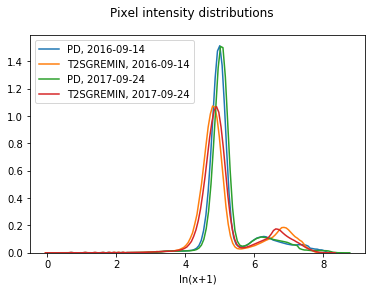

In [12]:
fig, ax = plt.subplots()
for (sequence, date), image in scans.items():
    sns.distplot(np.log1p(image.flatten()), hist=False, label=f'{sequence}, {date}', ax=ax)
ax.set_xlabel('ln(x+1)')
fig.suptitle('Pixel intensity distributions');

There are some minor differences, but in general the distributions are similar enough for the model to work properly for both sequences.
We might consider using two separate standarization pipelines, that would make them even more similar.

---

# Perform inferencing

We'll use [AlexNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_alexnet) adapted for MRI scans, i.e. with a single color channel (grayscale) in the input, and 2 output units.

We'll use this model to predict the probability of the two classes, "healthy" and "injured", for each slice, and compare the results for the two healing stages (2016-09-14 and 2017-09-24) and the two MRI sequences (PD and T2\*GREMIN).

First we need to load the model and the weights:

In [13]:
net = caffe.Net('AlexNet/deploy.prototxt',
                'AlexNet/snapshot_iter_20000.caffemodel',
                caffe.TEST)

# make sure model uses square images
assert net.blobs['data'].shape[2] == net.blobs['data'].shape[3]
input_size = net.blobs['data'].shape[2]

print(f'network input {input_size}x{input_size}')

network input 227x227


We also need to scale and reshape images, so they match network input shape.
We need to downscale images from 512x512 to 227x227 and add an additional dimension for the color channel.

In other words, we need to transform each image of shape Nx512x512 into Nx1x227x227 matrix,
where N is the number of slices.

In [14]:
scaling_factor = input_size / image_size

images = {}
for key, image in scans.items():
    images[key] = np.expand_dims([ndimage.zoom(img, scaling_factor, order=1)
                                  for img in image], 1)

# make sure we got correct size
for image in images.values():
    assert image.shape[1:] == (1, input_size, input_size)

Let's check how it affected an image:

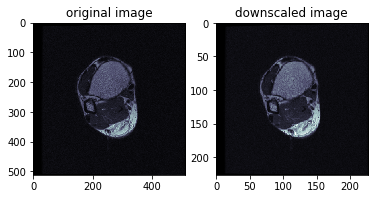

In [15]:
key = ('PD', '2016-09-14')
slice_num = 16

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(scans[key][slice_num], cmap='bone')
ax1.set_title('original image')

ax2.imshow(images[key][slice_num, 0], cmap='bone')
ax2.set_title('downscaled image');

Now we're ready to predict probabilities of the two classes for all slices in all 4 scans

In [16]:
results = {}
for key, image in images.items():
    # number of slices == batch size
    net.blobs['data'].reshape(len(image), 1, input_size, input_size)
    image_results = net.forward_all(data=image)['prob']
    results[key] = image_results

Let's plot the results:

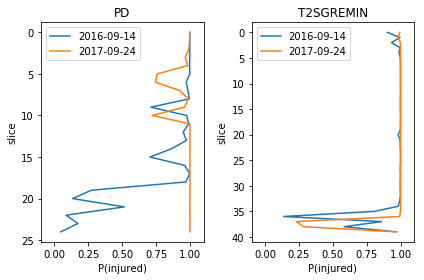

In [17]:
fig, axs = plt.subplots(ncols=2)

for sequence, ax in zip(('PD', 'T2SGREMIN'), axs):
    for date in ('2016-09-14', '2017-09-24'):
        result = results[(sequence, date)][:, 1]
        ax.plot(result, range(len(result)), label=date)
    ax.set_title(sequence)
    ax.invert_yaxis()
    ax.legend()
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel('P(injured)')
    ax.set_ylabel('slice')

fig.tight_layout()